In [52]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [1]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

SQLalchemy is not installed. No support for SQL output.


In [2]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [3]:
distribution = stepmodel.read_zip(training_folder + r'model/transport/distribution.zip')
pt = stepmodel.read_zip(training_folder + r'model/transport/pruning_pathfinder.zip')
car = stepmodel.read_zip(training_folder + r'model/transport/aon_pathfinder.zip')

read_hdf: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 95.10it/s]


Model epsg not defined: setting epsg to default one: 4326
Model coordinates_unit not defined: setting coordinates_unit to default one: degree


read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 19.86it/s]


In [4]:
sm = pt.copy()
sm.car_los = car.car_los
sm.volumes = distribution.volumes
# each segment will be processed independently in the logit
sm.segments = ['car_owner', 'pt_captive'] 

# LOGIT SCALES

In [5]:
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    time=-0.00055, 
    price=-1.0, 
    transfers=-0.25, 
    mode=1.0, 
    pt_mode=1.0, 
    pt_path=0.1
)

In [6]:
sm.utility_values.T

value,time,price,ntransfers,mode_utility
segment,,,,
root,-0.00055,-1.0,-0.25,1.0
car_owner,-0.00055,-1.0,-0.25,1.0
pt_captive,-0.00055,-1.0,-0.25,1.0


In [7]:
sm.logit_scales.T # phi

route_type,root,car,walk,subway,tram,bus,rail,pt
segment,,,,,,,,
root,1.0,0.01,0.01,0.1,0.1,0.1,0.1,1.0
car_owner,1.0,0.01,0.01,0.1,0.1,0.1,0.1,1.0
pt_captive,1.0,0.01,0.01,0.1,0.1,0.1,0.1,1.0


In [8]:
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100 # PT captive can not use the car
sm.mode_utility.T

route_type,root,car,walk,subway,tram,bus,rail
segment,,,,,,,
root,0,0,0,0,0,0,0
car_owner,0,0,0,0,0,0,0
pt_captive,0,-100,0,0,0,0,0


In [9]:
sm.mode_nests.T # nested structure can be set for each segment

route_type,root,car,walk,subway,tram,bus,rail,pt
segment,,,,,,,,
root,NaN,root,root,pt,pt,pt,pt,root
car_owner,NaN,root,root,pt,pt,pt,pt,root
pt_captive,NaN,root,root,pt,pt,pt,pt,root


# UTILITY EVALUATION
## add relevant columns to path dataframes

In [10]:
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(lambda x: max(len(x)-1, 0))
sm.pt_los['price'] = 0
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

## calculate utility

In [11]:
# builds 'time' in pt_los based on the paths
sm.analysis_pt_time() 

# builds 'route_type' in pt_los based on 'route_types'
sm.analysis_pt_route_type(hierarchy=[ 'car','rail', 'subway', 'tram', 'bus', 'walk'])
sm.analysis_car_route_type() # add route_type = 'car' in car_los

# concatenate pt_los and car_los
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p))

# add segment specific mode utility column
sm.analysis_mode_utility()

car_owner
pt_captive


## calulate the utilities and the probabilities

In [12]:
sm.initialize_logit()
sm.step_logit(verbose=True)

car_owner
path utilities bus 0.1 -> bus
path utilities car 0.01 -> car
path utilities rail 0.1 -> rail
path utilities subway 0.1 -> subway
path utilities tram 0.1 -> tram
path utilities walk 0.01 -> walk
mode utilities ['subway', 'tram', 'bus', 'rail'] 1.0 -> pt
mode utilities ['car', 'walk', 'pt'] 1.0 -> root
mode probabilities root 1.0 -> ['car', 'walk', 'pt']
mode probabilities pt 1.0 -> ['subway', 'tram', 'bus', 'rail']
path probabilities bus 0.1 -> bus
path probabilities car 0.01 -> car
path probabilities rail 0.1 -> rail
path probabilities subway 0.1 -> subway
path probabilities tram 0.1 -> tram
path probabilities walk 0.01 -> walk
pt_captive
path utilities bus 0.1 -> bus
path utilities car 0.01 -> car
path utilities rail 0.1 -> rail
path utilities subway 0.1 -> subway
path utilities tram 0.1 -> tram
path utilities walk 0.01 -> walk
mode utilities ['subway', 'tram', 'bus', 'rail'] 1.0 -> pt
mode utilities ['car', 'walk', 'pt'] 1.0 -> root
mode probabilities root 1.0 -> ['car', 'w

In [13]:
sm.od_probabilities.head()

(car_owner, root)  (car_owner, walk)  (car_owner, car)  \
zone_0 zone_0                  1           0.500000          0.500000   
       zone_1                  1           0.458838          0.541162   
       zone_2                  1           0.444821          0.555179   
       zone_3                  1           0.173064          0.356708   
       zone_4                  1           0.143941          0.372331   

               (car_owner, pt)  (car_owner, rail)  (car_owner, bus)  \
zone_0 zone_0         0.000000                0.0          0.000000   
       zone_1         0.000000                0.0          0.000000   
       zone_2         0.000000                0.0          0.000000   
       zone_3         0.470228                0.0          0.249437   
       zone_4         0.483728                0.0          0.229792   

               (car_owner, tram)  (car_owner, subway)  (pt_captive, root)  \
zone_0 zone_0                0.0             0.000000                   1   
       zone_1                0.0             0.000000                   1   
       zone_2                0.0             0.000000                   1   
       zone_3                0.0             0.220792                   1   
       zone_4                0.0             0.253936                   1   

               (pt_captive, walk)  (pt_captive, car)  (pt_captive, pt)  \
zone_0 zone_0            1.000000                0.0          0.000000   
       zone_1            1.000000                0.0          0.000000   
       zone_2            1.000000                0.0          0.000000   
       zone_3            0.269028                0.0          0.730972   
       zone_4            0.229326                0.0          0.770674   

               (pt_captive, rail)  (pt_captive, bus)  (pt_captive, tram)  \
zone_0 zone_0                 0.0           0.000000                 0.0   
       zone_1                 0.0           0.000000                 0.0   
       zone_2                 0.0           0.000000                 0.0   
       zone_3                 0.0           0.387750                 0.0   
       zone_4                 0.0           0.366104                 0.0   

               (pt_captive, subway)  
zone_0 zone_0              0.000000  
       zone_1              0.000000  
       zone_2              0.000000  
       zone_3              0.343222  
       zone_4              0.404570

In [14]:
sm.od_utilities.head() 

(car_owner, root)  (car_owner, walk)  (car_owner, car)  \
zone_0 zone_0           0.693147           0.000000          0.000000   
       zone_1           0.393275          -0.385784         -0.220761   
       zone_2           0.295841          -0.514243         -0.292623   
       zone_3           0.725638          -1.028457         -0.305200   
       zone_4           0.569590          -1.368763         -0.418382   

               (car_owner, pt)  (car_owner, rail)  (car_owner, bus)  \
zone_0 zone_0             -inf               -inf              -inf   
       zone_1             -inf               -inf              -inf   
       zone_2             -inf               -inf              -inf   
       zone_3        -0.028898               -inf         -0.662912   
       zone_4        -0.156642               -inf         -0.900990   

               (car_owner, tram)  (car_owner, subway)  (pt_captive, root)  \
zone_0 zone_0               -inf                 -inf            0.000000   
       zone_1               -inf                 -inf           -0.385784   
       zone_2               -inf                 -inf           -0.514243   
       zone_3               -inf            -0.784897            0.284482   
       zone_4               -inf            -0.801083            0.103848   

               (pt_captive, walk)  (pt_captive, car)  (pt_captive, pt)  \
zone_0 zone_0            0.000000               -inf              -inf   
       zone_1           -0.385784               -inf              -inf   
       zone_2           -0.514243               -inf              -inf   
       zone_3           -1.028457               -inf         -0.028898   
       zone_4           -1.368763               -inf         -0.156642   

               (pt_captive, rail)  (pt_captive, bus)  (pt_captive, tram)  \
zone_0 zone_0                -inf               -inf                -inf   
       zone_1                -inf               -inf                -inf   
       zone_2                -inf               -inf                -inf   
       zone_3                -inf          -0.662912                -inf   
       zone_4                -inf          -0.900990                -inf   

               (pt_captive, subway)  
zone_0 zone_0                  -inf  
       zone_1                  -inf  
       zone_2                  -inf  
       zone_3             -0.784897  
       zone_4             -0.801083

In [15]:
sm.los.head(2) # utility and probability columns were added

,access_time,alighting_links,alightings,all_walk,boarding_links,boarding_time,boardings,broken_modes,broken_route,destination,...,route_type,route_types,time,time_link_path,transfers,waiting_time,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)"
0,0.000000,[],[],True,[],0.0,[],"{subway, tram, bus, rail}",NaN,zone_50,...,walk,(),0.000000,0.0,[],0.0,0.000000,0.000000,0.500000,1.0
1,718.362366,[],[],True,[],0.0,[],"{subway, tram, bus, rail}",NaN,zone_46,...,walk,(),718.362366,0.0,[],0.0,-0.395099,-0.395099,0.459493,1.0


# ASSIGNMENT

In [16]:
sm.pt_los = sm.los.copy()
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type'] != 'car']
sm.step_pt_assignment(
    volume_column=None,
    road=True,
    boardings=True,
    alightings=True,
    transfers=True,
)

pt_captive: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


# XLSX EXPORT

In [17]:
sm.analysis_pt_length()
sm.analysis_pt_time()

sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
sm.summary_od(inplace=True)

sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

In [54]:
stacks = {name[6:]: attr for name, attr in sm.__dict__.items() if name[:5] == 'stack'}
with pd.ExcelWriter(training_folder + r'model/%s/stacks.xlsx'%scenario) as writer:  
    for name, stack in stacks.items():
        stack.reset_index().to_excel(writer, sheet_name=name, index=False)

# GEOJSON EXPORT

In [19]:
sm.to_json(training_folder + 'model/json', omitted_attributes=['pt_los', 'car_los'])

to_hdf(overwriting):  78%|███████████████████████████████████████████████▊             | 40/51 [00:34<00:03,  2.98it/s]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes


to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 51/51 [00:39<00:00,  1.29it/s]


# ZIP EXPORT

In [53]:
sm.to_zip(training_folder + 'model/%s/logit.zip'%scenario, omitted_attributes=['los'])

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 51/51 [00:06<00:00,  7.90it/s]


# PLOT

In [47]:
import numpy as np
paths = sm.pt_los
link_routes = sm.links['route_short_name'].to_dict()
def link_path_to_routes(link_path):
    routes = [link_routes[l] for l in link_path]
    used = set()
    rsn = []
    for route in routes:
        if route not in used:
            rsn.append(route)
        used.add(route)
    return rsn

paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
paths['ntransfers'] = paths['transfers'].apply(len)

def title(paths):
    paths['min'] = np.round(paths['time'] / 60).astype(int)
    mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
    title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
    title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
    title += ' | '+  paths['min'].astype(str) + ' mins | '
    title += paths['route_path'].apply(lambda l: '—>'.join(l) )
    title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
    title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
    return title


paths['title'] = title(paths)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:16<00:00,  2.11s/it]


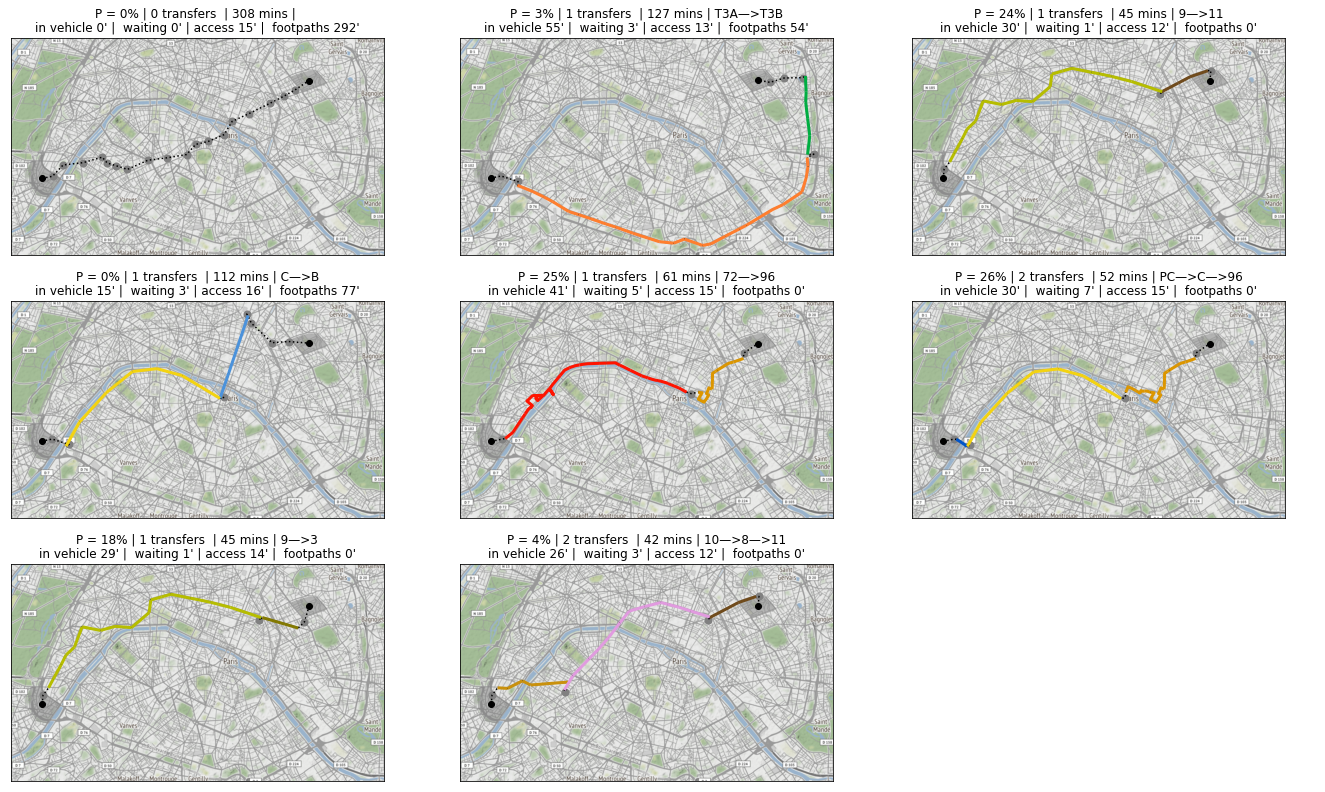

In [48]:
origin, destination='zone_74',  'zone_105'
n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

rows = 2
if n > 6:
    rows = 3
if n > 12:
    rows = 4

columns = n // rows + bool(n%rows)


url = 'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'
fig, axes = sm.plot_separated_paths(
    origin, destination, rows=rows, figsize=[20, 20],
    title='title', constrained_layout=True,
    basemap_url=url, zoom=13
)
ax = fig.get_axes()[0]
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
fig.constrained_layout = True

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.02it/s]


Text(0.5, 1, 'Public Transport Assignment on Bus Lines (Stochastic)')

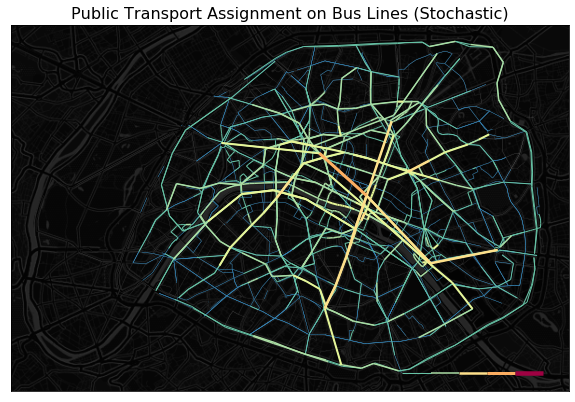

In [36]:
%matplotlib inline
from syspy.syspy_utils import data_visualization as dv
bandwidth = dv.bandwidth
power=0.5
lv = [100, 1000, 2000, 5000, 7000, 15000]
url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'

i_links = sm.loaded_links.loc[sm.loaded_links.road_length.isnull()]
df = pd.concat([i_links, sm.road_links])
df['pt'] = df['pt_captive'] 
df = df.loc[df['pt'] > 0]

plot= bandwidth(
    df, value='pt', power=power, figsize=[10, 10], legend_values=lv, scale=0.5,
    label_kwargs={'color':'white', 'fontsize':14}
)
dv.add_basemap(plot, url=url, zoom=12)
plot.set_title('Public Transport Assignment on Bus Lines (Stochastic)', fontsize=16)